# Summary

1. [Solve Dependencies](#solve-dependencies)
2. [Create Dict to Store Data Split and Augmentation Settings](#create-dict-to-store-data-split-and-augmentation-settings)
3. [Create Labels File](#create-labels-file)
4. [Data Split](#data-split)
5. [SimCLR](#simclr)
6. [Downstream Task](#downstream-task)
7. [Baseline](#baseline)
8. [Test](#test)


# Solve Dependencies
<a id="solve-dependencies"></a>


In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import json
import random
from collections import Counter

import numpy as np
import pandas as pd
import typing as tp
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Set the seed
SEED = 42

pl.seed_everything(seed=SEED, workers=True)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Ensure deterministic behavior for CUDA
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


Seed set to 42


# Create Dict to Store Data Split and Augmentation Settings
<a id="create-dict-to-store-data-split-and-augmentation-settings"></a>

Just to save training information. (Logs)

In [2]:
IMAGE_SIZE = 224

data_dict = {
    'split': None,
    'aug_transforms': None,
    'k': None,
    'image_size': IMAGE_SIZE
}

# Create Labels File
<a id="create-labels-file"></a>

Each class is in a different path. I prefer to work with labels in a CSV file.

In [3]:
def create_labels_csv(root_dir: str, output_csv: str) -> None:
    """
    Create a CSV file containing the filenames and labels of the images in the dataset.

    Args:
        root_dir (str): The root directory containing the class folders.
        output_csv (str): The output CSV file where the data will be saved.

    """

    # Initialize an empty list to hold the data
    data = []

    # Define class names and their corresponding labels
    class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

    # Loop through each class folder
    for class_name in class_names:
        class_folder = os.path.join(root_dir, class_name)
        
        # Check if the class folder exists
        if not os.path.exists(class_folder):
            print(f"Warning: {class_folder} does not exist.")
            continue
        
        # Loop through all files in the class folder
        for filename in os.listdir(class_folder):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Add any other image formats if needed
                # Create a tuple of (filename, label)
                data.append((class_name+'/'+filename, class_name))
    
    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=['filename', 'label'])
    
    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)
    print(f"CSV file created at: {output_csv}")

In [4]:
# Specify the directory and the output CSV file name
root_directory = 'data/train'  # Path to the train directory
output_csv_file = 'data/train.csv'  # Output CSV file name

create_labels_csv(root_directory, output_csv_file)

CSV file created at: data/train.csv


# Data Split
<a id="data-split"></a>


### Define Dataset Class

In [5]:
class_map = {
    'CNV': 0,
    'DME': 1,
    'DRUSEN': 2,
    'NORMAL': 3
}

class OCTDataset(Dataset):
    """
    Dataset class for loading OCT images and their labels.

    Args:
        images_dir (str): The directory where the images are stored.
        labels_csv (str): The path to the CSV file containing the image filenames and labels.
        indices (list, optional): A list of indices to select a subset of the data. Default: None.
        transform (Compose, optional): A torchvision transform to apply to the images. Default: None.
    """

    def __init__(
        self,
        images_dir: str,
        labels_csv: str,
        indices: tp.Optional[tp.List[int]] = None,
        transform: tp.Optional[transforms.Compose] = None,
    ):
        self.images_dir = images_dir
        self.labels_csv = labels_csv
        self.transform = transform
        
        # Carrega o arquivo CSV e filtra pelos índices, se fornecidos
        labels_df = pd.read_csv(labels_csv)
        
        if indices is not None:
            # Seleciona apenas os índices fornecidos
            labels_df = labels_df.iloc[indices].reset_index(drop=True)
        
        # Armazena os caminhos das imagens e rótulos como listas
        self.image_paths = [os.path.join(images_dir, fname) for fname in labels_df['filename']]
        self.labels = labels_df['label'].tolist()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Carrega a imagem a partir do caminho
        image = Image.open(self.image_paths[idx]).convert("L")
        
        # Aplica as transformações, se existirem
        if self.transform:
            image = self.transform(image)
        
        # Retorna a imagem e o rótulo
        label = torch.tensor(class_map[self.labels[idx]])
        return image, label

### Define Split Function

In [6]:
def create_split_datasets(
    dataset: OCTDataset, 
    split_ratio: int=0.8
) -> tp.Tuple[OCTDataset, OCTDataset, OCTDataset, OCTDataset]:
    """
    Split the dataset in 4 parts: bigger_train, bigger_val, smaller_train, smaller_val.
    The bigger part is split in 60% train and 40% validation.
    The smaller part is split in 80% train and 20% validation.

    Args:
        dataset (OCTDataset): The dataset to split.
        split_ratio (float): The ratio to split the dataset. Default: 0.8.

    Returns:
        Tuple[OCTDataset, OCTDataset, OCTDataset, OCTDataset]: The split datasets
    """

    # Divide o dataset em duas partes principais
    bigger_part_indices, smaller_part_indices = train_test_split(
        range(len(dataset)),
        test_size=(1 - split_ratio),
        stratify=dataset.labels,
        random_state=SEED
    )

    # Divide a parte maior em treino e validação
    bigger_train_indices, bigger_val_indices = train_test_split(
        bigger_part_indices,
        test_size=0.4,
        stratify=np.array(dataset.labels)[bigger_part_indices],
        random_state=SEED
    )

    # Divide a parte menor em treino e validação
    smaller_train_indices, smaller_val_indices = train_test_split(
        smaller_part_indices,
        test_size=0.2,
        stratify=np.array(dataset.labels)[smaller_part_indices],
        random_state=SEED
    )

    # Cria os datasets de treino e validação
    bigger_train_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=bigger_train_indices,
        transform=dataset.transform
    )

    bigger_val_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=bigger_val_indices,
        transform=dataset.transform
    )

    # Criar os datasets de treino e validação
    smaller_train_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=smaller_train_indices,
        transform=dataset.transform
    )

    smaller_val_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=smaller_val_indices,
        transform=dataset.transform
    )
    
    return bigger_train_dataset, bigger_val_dataset, smaller_train_dataset, smaller_val_dataset


### Execute Split

In [7]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),    # Resize images
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize the images
        mean=[0.5],
        std=[0.5]
    )
])

# Instantiate the dataset
root_dir = 'data/train'  # Replace with the actual path to your dataset root
dataset = OCTDataset(
    images_dir=root_dir,
    labels_csv='data/train.csv',
    transform=transform
)

# Dividir o conjunto de treino em auto-supervisão e downstream
self_supervised_train, self_supervised_val, supervised_train, supervised_val = create_split_datasets(
    dataset, split_ratio=0.9)

In [8]:
# Check the size training dataset
print("Train:", len(dataset))

# Check the size of each dataset
print("Self-Supervised Train:", len(self_supervised_train))
print("Self-Supervised Validation:", len(self_supervised_val))
print("Downstream Train:", len(supervised_train))
print("Downstream Validation:", len(supervised_val))

Train: 108309
Self-Supervised Train: 58486
Self-Supervised Validation: 38992
Downstream Train: 8664
Downstream Validation: 2167


In [9]:
# Save the split information
data_dict['split'] = {
    'self_supervised_train': len(self_supervised_train),
    'self_supervised_val': len(self_supervised_val),
    'supervised_train': len(supervised_train),
    'supervised_val': len(supervised_val)
}

### Plot the Splits

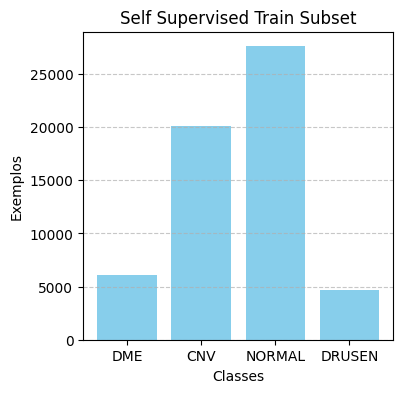

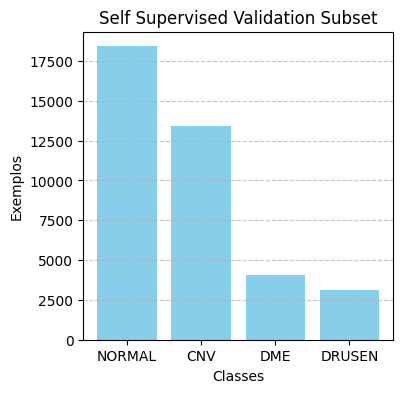

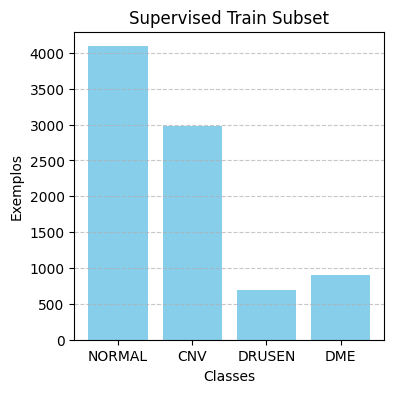

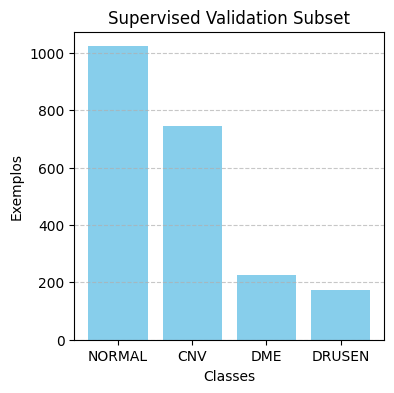

In [10]:
def plot_class_distribution(dataset, dataset_name):
    labels = np.array(dataset.labels)  # Obtém os rótulos do dataset
    
    class_counts = Counter(labels)  # Conta os exemplos por classe

    # Tamanho do gráfico
    plt.figure(figsize=(4, 4))  # Ajusta o tamanho do gráfico (largura, altura)
    
    # Gráfico de barras
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Exemplos")
    plt.title(f"{dataset_name}")

    # Mostra a grade para melhor visualização
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

# Plotar distribuições para cada conjunto
plot_class_distribution(self_supervised_train, "Self Supervised Train Subset")
plot_class_distribution(self_supervised_val, "Self Supervised Validation Subset")
plot_class_distribution(supervised_train, "Supervised Train Subset")
plot_class_distribution(supervised_val, "Supervised Validation Subset")

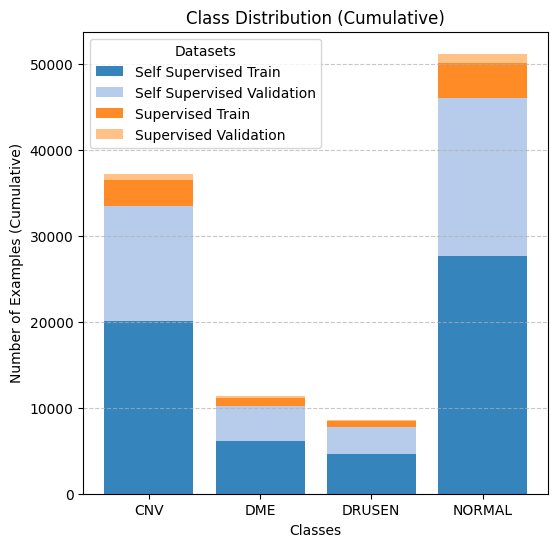

In [11]:
def plot_cumulative_class_distribution(datasets, dataset_names):
    from collections import Counter

    # Inicializa o contador cumulativo de classes
    cumulative_counts = {name: Counter() for name in dataset_names}

    # Calcula as distribuições de classe para cada conjunto
    for dataset, name in zip(datasets, dataset_names):
        labels = np.array(dataset.labels)  # Obtém os rótulos do dataset
        counts = Counter(labels)          # Conta os exemplos por classe
        cumulative_counts[name] = counts  # Armazena os contadores

    # Todas as classes presentes em qualquer dataset
    all_classes = sorted(set().union(*[counts.keys() for counts in cumulative_counts.values()]))

    # Organiza os dados para plotagem cumulativa
    data = {name: [cumulative_counts[name].get(cls, 0) for cls in all_classes] for name in dataset_names}

    # Define as cores: azul e laranja em tons claro e escuro
    colors = ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78"]  # Azul escuro, azul claro, laranja escuro, laranja claro

    # Gráfico de barras empilhadas
    plt.figure(figsize=(6, 6))
    bottom = np.zeros(len(all_classes))  # Inicia a base para as barras empilhadas

    for name, counts, color in zip(dataset_names, data.values(), colors):
        plt.bar(all_classes, counts, bottom=bottom, label=name, alpha=0.9, color=color)
        bottom += np.array(counts)  # Atualiza a base

    plt.xlabel("Classes")
    plt.ylabel("Number of Examples (Cumulative)")
    plt.title("Class Distribution (Cumulative)")
    plt.legend(title="Datasets", loc="upper left")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# Dados de entrada
datasets = [self_supervised_train, self_supervised_val, supervised_train, supervised_val]
dataset_names = ["Self Supervised Train", "Self Supervised Validation", "Supervised Train", "Supervised Validation"]

# Chamada da função
plot_cumulative_class_distribution(datasets, dataset_names)


### Show Examples of Each Label

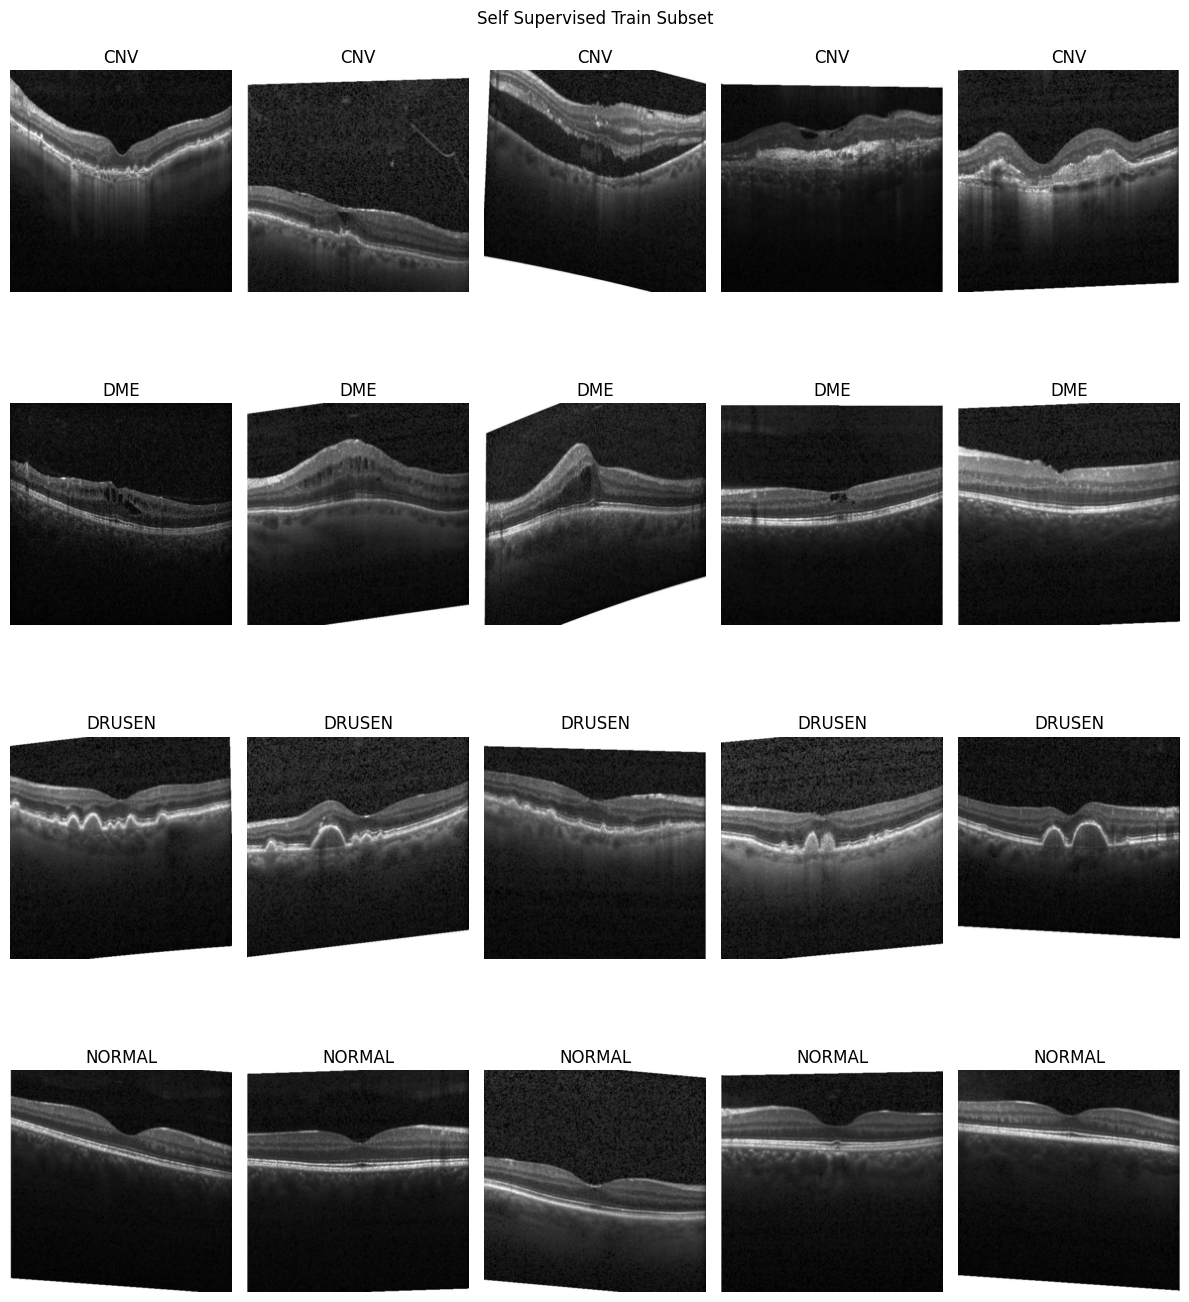

In [12]:
def plot_examples(dataset, dataset_name):
    # Define a lista de classes
    class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    
    # Define o tamanho do gráfico
    plt.figure(figsize=(12, 14))
    
    # Loop através de cada classe
    for i, class_name in enumerate(class_names):
        # Filtra os exemplos da classe atual
        class_indices = [idx for idx, label in enumerate(dataset.labels) if label == class_name]
        
        # Seleciona os primeiros 5 exemplos
        example_indices = class_indices[:5]
        
        # Loop através dos exemplos
        for j, idx in enumerate(example_indices):
            # Carrega a imagem
            image, _ = dataset[idx]
            
            # Desnormaliza a imagem
            image = (image * 0.5) + 0.5
            
            # Adiciona a sub-figura
            plt.subplot(4, 5, i * 5 + j + 1)
            plt.imshow(image.squeeze(), cmap='gray')
            plt.title(class_name)
            plt.axis('off')
    
    # Ajusta o layout
    plt.tight_layout()
    plt.suptitle(dataset_name)
    plt.show()

# Plotar exemplos para cada conjunto
plot_examples(self_supervised_train, "Self Supervised Train Subset")

# Set Checkpoint Path, Device, and Number of Workers

In [13]:
# Path to the folder where the pretrained models are saved.
#
CHECKPOINT_PATH = "saved_models"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility.
#
torch.backends.cudnn.deterministic = True

# Ensure that it will use the most suitable (fastest) algoritms for this hardware.
#
torch.backends.cudnn.benchmark = False

# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores.
#
NUM_WORKERS = os.cpu_count()

# It will use GPUs whenever they are available.
#
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cpu
Number of workers: 8


# SimCLR
<a id="simclr"></a>

### Define Augmentation Schema

In [19]:
class Cutout(object):
    def __init__(self, mask_size, p=0.5, replace=0.0):
        """
        Cutout augmentation.

        Args:
            mask_size (int): Size of the square mask to cut out.
            p (float): Probability of applying cutout. Default is 0.5.
            replace (float): Value to fill in the masked area. Default is 0.0.
        """
        self.mask_size = mask_size
        self.p = p
        self.replace = replace

    def __call__(self, img):
        """
        Apply Cutout on an image.

        Args:
            img (Tensor): Input image of shape (C, H, W).

        Returns:
            Tensor: Image with a random cutout applied.
        """
        if random.uniform(0, 1) > self.p:
            return img  # Do nothing with probability 1-p

        _, h, w = img.shape

        # Choose center of the cutout region
        y = random.randint(0, h)
        x = random.randint(0, w)

        # Calculate bounding box
        y1 = max(0, y - self.mask_size // 2)
        y2 = min(h, y + self.mask_size // 2)
        x1 = max(0, x - self.mask_size // 2)
        x2 = min(w, x + self.mask_size // 2)

        # Apply the cutout
        img[:, y1:y2, x1:x2] = self.replace
        return img

In [20]:
class AddNoise:
    """
    Custom transform to add noise with a specific probability.

    Args:
        noise_std (float): Standard deviation of the noise.
        p (float): Probability of applying the noise.

    """
    def __init__(self, noise_std=0.1, p=0.5):
        self.noise_std = noise_std
        self.p = p

    def __call__(self, img):
        if torch.rand(1).item() < self.p:  # Apply noise with probability p
            noise = torch.randn_like(img) * self.noise_std
            img = img + noise
        return img

In [21]:
class ProbabilisticTransform:
    """
    Wrapper to apply a transform with a specified probability.

    Args:
        transform (callable): The transform to be applied.
        p (float): Probability of applying the transform
    """
    def __init__(self, transform, p=0.5):
        self.transform = transform
        self.p = p

    def __call__(self, x):
        if random.random() < self.p:
            return self.transform(x)
        return x

In [22]:
class ContrastiveTransformations(object):
    """
    Apply a series of augmentations to the input image.

    Args:
        k (int): Number of augmentations to apply.    
    """

    def __init__(self, k=5):
        self.k = k

        # Base PIL transforms
        self.base_transforms = transforms.Compose([
            ProbabilisticTransform(transforms.RandomResizedCrop(
                size=IMAGE_SIZE, scale=(0.5, 1.0)), p=0.8),
            transforms.RandomHorizontalFlip(p=0.8),
            transforms.RandomVerticalFlip(p=0.8),
            ProbabilisticTransform(transforms.ColorJitter(
                brightness=0.3, contrast=0.3), p=0.8),
            ProbabilisticTransform(transforms.RandomRotation(degrees=180), p=0.8),
            ProbabilisticTransform(transforms.RandomAffine(
                degrees=0, translate=(0.1, 0.1), shear=10), p=0.8),
            ProbabilisticTransform(transforms.GaussianBlur(kernel_size=(3, 3)), p=0.8)
        ])

        # Convert PIL to tensor
        self.to_tensor = transforms.ToTensor()

        # Tensor-specific transforms
        self.tensor_transforms = transforms.Compose([
            AddNoise(noise_std=0.05, p=0.8),  # Add noise 50% of the time
            Cutout(mask_size=16, p=0.8, replace=0.0),  # Add Cutout
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])

    def __call__(self, x):
        augmented_images = []
        for _ in range(self.k):
            # Apply base transforms
            img = self.base_transforms(x)
            # Convert to tensor and apply tensor transforms
            img_tensor = self.to_tensor(img)
            img_tensor = self.tensor_transforms(img_tensor)
            augmented_images.append(img_tensor)

        return augmented_images
    
# Save the augmentation information
data_dict['aug_transforms'] = _ih[-1]


### Checkout Some Augmented Images on Our Dataset

<Figure size 640x480 with 0 Axes>

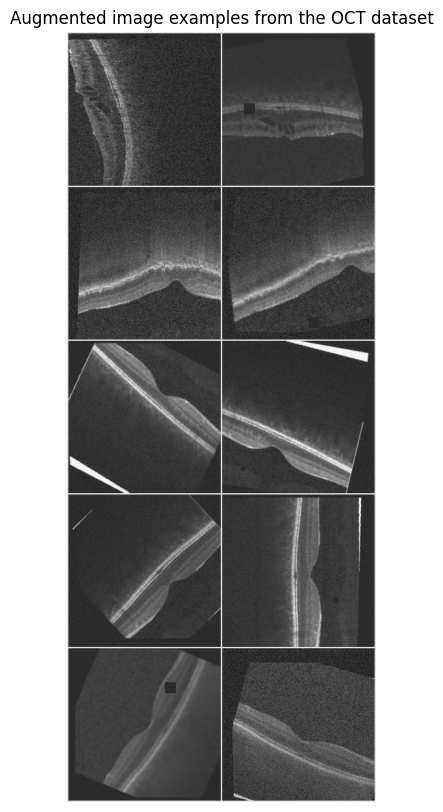

In [23]:
# Set the number of augmentations to apply
K = 2

# Set contrastive transformations for the self-supervised training dataset.
self_supervised_train.transform = ContrastiveTransformations(k=K)

# Set contrastive transformations for the self-supervised validation dataset.
self_supervised_val.transform = ContrastiveTransformations(k=K)

# Set k in the data dictionary
data_dict['k'] = K

# Defina o número de imagens aumentadas que deseja visualizar
N = 5

# Extrair e empilhar N imagens aumentadas do dataset, aplicando as transformações
imgs = torch.stack([img for i in range(N) for img in self_supervised_train[i][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.squeeze().permute(1, 2, 0).cpu().numpy()

# Exibir o grid com matplotlib
plt.set_cmap('cividis')
plt.figure(figsize=(10, 10))
plt.title('Augmented image examples from the OCT dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### Implement the SimCLR Class

Let's implement the SimCLR architecture. The loss function is given by:

\begin{align}
{\cal L}_{i,j} &=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}\\
&=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right],
\end{align}

where sim is the similarity function (in our case, the cosine similarity):

$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}.
$$


In [24]:
import pytorch_lightning as pl

class SimCLR(pl.LightningModule):
    '''
    SimCLR model with a SqueezeNet backbone.

    Args:
        hidden_dim: The dimension of the hidden layer in the projection head. 
            Number of units in the hidden layer.
        lr: The learning rate for the optimizer.
        temperature: The temperature parameter for the contrastive loss.
        weight_decay: The weight decay for the optimizer.
        max_epochs: The maximum number of epochs for training.

    '''

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Usando pesos pré-treinados do ImageNet
        self.convnet = torchvision.models.squeezenet1_1(weights=None)

        # Replace the first convolutional layer to accept single-channel images
        self.convnet.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))

        # Replace the classifier head of SqueezeNet
        self.convnet.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling to shape [batch_size, 512, 1, 1]
            nn.Flatten(start_dim=1),       # Flatten to shape [batch_size, 512]
            nn.Linear(512, 4 * hidden_dim),  # Fully connected layer with output 4 * hidden_dim
            nn.ReLU(inplace=True),        # Activation function
            nn.Linear(4 * hidden_dim, hidden_dim)  # Fully connected layer with output hidden_dim
        )


    def configure_optimizers(self):
        '''
        Configures the optimizer and the learning rate scheduler.
        '''

        # Adam optimizer.
        #
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay)
        
        # Uses the cosine annealing schedule to set the learning rate (eta).
        # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html
        #
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.hparams.max_epochs,
            eta_min=self.hparams.lr/50)
        
        return [optimizer], [lr_scheduler]
    

    def forward(self, batch):
        # _ is a special variable that stores the last value in batch.
        imgs, _ = batch

        # Concat images in the zero dimension (rows).
        if isinstance(imgs, (list, tuple)):
            imgs = torch.cat(imgs, dim=0)

        # Encode all images using the representation extraction function
        # 
        # i.e. pass each image through the same architecture.
        backbone_feats = self.convnet.features(imgs)  # Backbone features
        # backbone_feats = backbone_feats.view(backbone_feats.size(0), -1)  # Flatten
        feats = self.convnet.classifier(backbone_feats)  # Pass through the projection head

        return feats


    def info_nce_loss(self, batch, mode='train'):
        '''
        This method defines the InfoNCE loss (SimCLR's paper loss) used in the pretext task learning.
        
        Computes the InfoNCE loss for the batch of images.

        Args:
            batch: The batch of images.
            mode: The mode of the model (train or val). [Log purposes]

        Returns:
            The InfoNCE loss for the batch of images.
        '''

        # _ is a special variable that stores the last value in batch.
        imgs, _ = batch

        # Concat images in the zero dimension (rows).
        if isinstance(imgs, (list, tuple)):
            imgs = torch.cat(imgs, dim=0)

        # Encode all images using the representation extraction function
        # 
        # i.e. pass each image through the same architecture.
        backbone_feats = self.convnet.features(imgs)  # Backbone features
        feats = self.convnet.classifier(backbone_feats)  # Pass through the projection head
        
        # Calculate cosine similarity. Similarity is computed along the
        # last dimension of the tensor (that's what dim=-1 means, like in Python's lists)
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)

        # Mask out cosine similarity to itself
        # (to avoid to compute similarity against itself):
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)

        # Find positive example -> batch_size//2 away from the original example
        # // is the integer division operator in Python:
        #
        # (Sligthly different from the paper, where they are indices 2k-1 and 2k)
        #
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)

        # Computing the InfoNCE loss:
        #
        cos_sim = cos_sim / self.hparams.temperature        
        result = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        result = result.mean()

        # Logging loss:
        #
        self.log(mode+'_loss', result, 
                 on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # Getting ranking position of positive example (i.e., we see how far it is
        # when compared with the negative examples). Useful to compute top-k metrics.
        #
        comb_sim = torch.cat([cos_sim[pos_mask][:,None], 
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

        # Logging ranking metrics:
        #
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean(), 
                 on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean(), 
                 on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean(), 
                 on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return result


    # Training step method.
    #
    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')


    # Validation step method.
    #
    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

print("SimCLR model sucessfully implemented.")

SimCLR model sucessfully implemented.


### Execute the Pretext Task Learning

In [40]:
%load_ext tensorboard
%tensorboard --logdir saved_models/Pretext-Scratch/lightning_logs --port 6010

In [ ]:
# Set seed
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    

def train_simclr(batch_size, max_epochs=500, **kwargs):
    """
    Function to train the SimCLR model.

    Args:   
        batch_size: The batch size.
        max_epochs: The maximum number of epochs.
        **kwargs: Additional arguments to pass to the model.
    
    Returns:
        The trained SimCLR model.
    """

    # Instantiation of a Pytorch Lightining Trainer object:
    #
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, 'Pretext-Scratch'),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=False, 
                mode='max', 
                monitor='val_acc_top5', 
                filename='last'),
            LearningRateMonitor('epoch')])
    
    # Optional logging argument, it is not necessary.
    #
    trainer.logger._default_hp_metric = None 
    
    # Loading training data."pin_memory=True" is useful when training with GPU (CUDA),
    # because it stores the data into the pinned memory, rendering the process faster.
    # "drop_last=True" ignores the last minibatch of your epoch if is smaller than the
    # previous minibatches.
    #
    # Contrastive transformations are applied to the self-supervised training dataset.
    train_loader = DataLoader(
        self_supervised_train,
        batch_size=batch_size, 
        shuffle=True,
        drop_last=True, 
        pin_memory=True, 
        num_workers=NUM_WORKERS,
        worker_init_fn=worker_init_fn,  # Set DataLoader worker seed
        generator=torch.Generator().manual_seed(SEED))  # Set DataLoader generator seed
    
    # Loading validation data (for hyperparameter tuning). 
    #
    val_loader = DataLoader(
        self_supervised_val,
        batch_size=batch_size, 
        shuffle=False,
        drop_last=False, 
        pin_memory=True,
        num_workers=NUM_WORKERS,
        worker_init_fn=worker_init_fn)  # Set DataLoader worker seed

    # Train model.
    #
    model = SimCLR(max_epochs=max_epochs, **kwargs)

    # Checa se existe um checkpoint para retomar
    #
    checkpoint_version = CHECKPOINT_PATH + '/Pretext-Scratch/lightning_logs/version_X/checkpoints/last.ckpt'
    if os.path.isfile(checkpoint_version):
        print(f"Checkpoint encontrado em {checkpoint_version}, retomando o treinamento...")
        trainer.fit(model, train_loader, val_loader, ckpt_path=checkpoint_version)
    else:
        print("Nenhum checkpoint encontrado, iniciando treinamento do zero...")
        trainer.fit(model, train_loader, val_loader)

    # Save data_dict as JSON in the same path as the model checkpoint
    checkpoint_dir = os.path.dirname(trainer.checkpoint_callback.best_model_path)
    data_dict_path = os.path.join(checkpoint_dir, 'data_dict.json')
    
    # Assuming 'data_dict' is already defined
    with open(data_dict_path, 'w') as f:
        json.dump(data_dict, f)
    print(f"data_dict saved to {data_dict_path}")

    # Get best checkpoint yielded by training.
    #
    model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model


# Let's train our SimCLR!
#
simclr_model = train_simclr(batch_size=16,
                            hidden_dim=32,
                            lr=5e-5,
                            temperature=0.07,
                            weight_decay=5e-4,
                            max_epochs=5)

### Checkout SimCLR Embeddings with t-SNE

Number of samples in val_loader: 38992
Found pretrained model at saved_models/Pretext-Scratch/lightning_logs/version_3/checkpoints/last.ckpt, loading...
Performing t-SNE on 1600 samples...


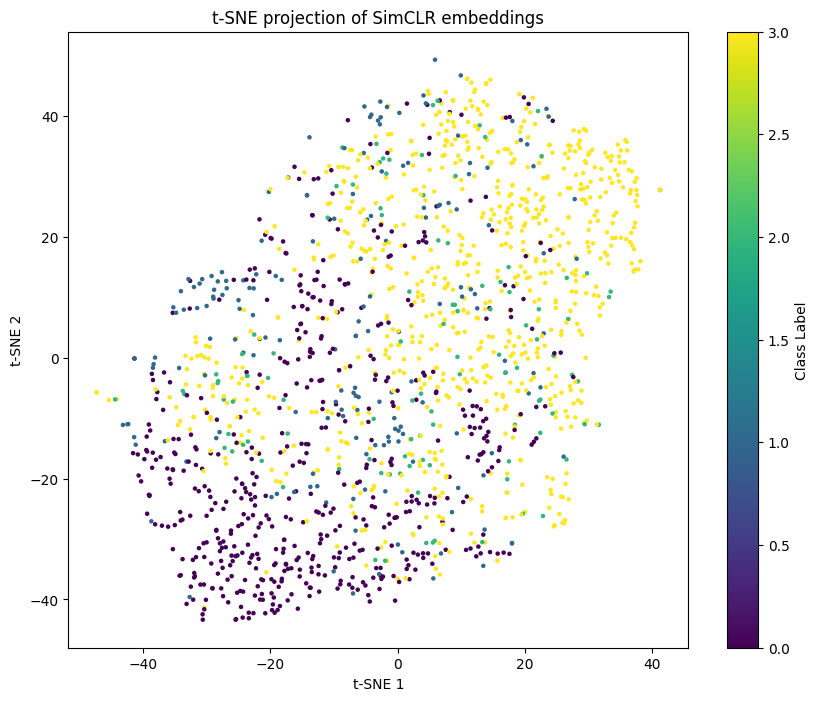

In [41]:
from sklearn.manifold import TSNE

# Define transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),    # Resize images
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize the images
        mean=[0.5],
        std=[0.5]
    )
])

self_supervised_val.transform = transform

# Carregar o DataLoader de validação
val_loader = DataLoader(
    self_supervised_val,
    batch_size=16, 
    shuffle=False,
    drop_last=False, 
    pin_memory=True, 
    num_workers=NUM_WORKERS)

# Verificar o número de amostras no dataset
print(f"Number of samples in val_loader: {len(val_loader.dataset)}")

# Check se o modelo pré-treinado existe e carregá-lo
checkpoint_version = CHECKPOINT_PATH + '/Pretext-Scratch/lightning_logs/version_3/checkpoints/last.ckpt'  
if os.path.isfile(checkpoint_version):
    print(f'Found pretrained model at {checkpoint_version}, loading...')
    model = SimCLR.load_from_checkpoint(checkpoint_version)

def tsne_evaluation(model, dataloader, num_samples=1000):
    """
    Avalia os embeddings aprendidos usando t-SNE.

    Args:
        model (SimCLR): Modelo SimCLR treinado.
        dataloader (DataLoader): DataLoader para o dataset a ser avaliado.
        num_samples (int): Número de amostras para visualização com t-SNE.

    Returns:
        None: Mostra o gráfico t-SNE.
    """
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dataloader):
            if len(features) >= num_samples:
                break  # Parar quando atingir o número desejado de amostras

            images = images.to(model.device)
            targets = targets.to(model.device)

            # Forward pass para obter os embeddings
            feats = model.forward((images, targets))

            # Verificar o formato das features
            # print(f"Batch {batch_idx}: features shape {feats.shape}, targets shape {targets.shape}")

            features.append(feats.cpu().numpy())
            labels.append(targets.cpu().numpy())

    # Concatenar todas as features e labels
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Verificar se temos amostras suficientes para o t-SNE
    if features.shape[0] < 2:
        raise ValueError(f"Not enough samples for t-SNE: {features.shape[0]} samples available. "
                         "Increase `num_samples` or ensure DataLoader has enough data.")

    # Aplicar t-SNE
    print(f"Performing t-SNE on {features.shape[0]} samples...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=0)
    features_2d = tsne.fit_transform(features)

    # Plotar os resultados
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', s=5)
    plt.colorbar(scatter, label='Class Label')
    plt.title('t-SNE projection of SimCLR embeddings')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

# Usar a função de avaliação
# Ajustar `num_samples` para ser menor que o número de amostras no dataset, se necessário
try:
    tsne_evaluation(model=model, dataloader=val_loader, num_samples=100)
except ValueError as e:
    print(f"Error during t-SNE evaluation: {e}")


# Downstream Task
<a id="downstream"></a>

### Implement the SqueezeNet Model for the Downstream Task

In [30]:
# Import f1_score from sklearn
from sklearn.metrics import f1_score

class SqueezeNetDownstream(pl.LightningModule):
    '''
    Simple baseline model using SqueezeNet for classification.
    Changes: Input channels from 3 to 1 and output size to match the number of labels.
    '''

    def __init__(self, lr, weight_decay, max_epochs=500, num_classes=4, class_weights=None):
        super().__init__()
        self.save_hyperparameters()
        self.class_weights = class_weights

        # Load pre-trained SqueezeNet and adjust the input and output layers
        self.convnet = torchvision.models.squeezenet1_1(weights=None)

        # Replace the first convolutional layer to accept single-channel images
        self.convnet.features[0] = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(2, 2),
            padding=(1, 1)
        )

        # Replace the classifier head of SqueezeNet
        self.convnet.classifier[1] = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(512, num_classes, kernel_size=(1, 1)),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        

    def configure_optimizers(self):
        '''
        Configures the optimizer and the learning rate scheduler.
        '''

        # Adam optimizer.
        #
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay)
        
        # Uses the cosine annealing schedule to set the learning rate (eta).
        # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html
        #
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.hparams.max_epochs,
            eta_min=self.hparams.lr/50)
        
        return [optimizer], [lr_scheduler]
    

    def forward(self, x):
        '''
        Forward pass for the baseline model.
        '''
        return self.convnet(x)
    

    def training_step(self, batch, batch_idx):
        '''
        Training step for classification.
        '''

        imgs, labels = batch
        preds = self.forward(imgs)  # Get predictions

        # If class weights are provided, use them in the loss calculation
        if self.class_weights is not None:
            loss = F.cross_entropy(preds, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(preds, labels)  # Standard loss without weights

        acc = (preds.argmax(dim=-1) == labels).float().mean()  # Calculate accuracy
        self.log('train_loss', loss, prog_bar=True, on_step=True)
        self.log('train_acc', acc, prog_bar=True)
        self.log('train_f1', f1_score(labels.cpu(), preds.argmax(dim=-1).cpu(), average='weighted'), prog_bar=True)
        return loss


    def validation_step(self, batch, batch_idx):
        '''
        Validation step for classification.
        '''
        imgs, labels = batch
        preds = self.forward(imgs)  # Get predictions

        # If class weights are provided, use them in the loss calculation
        if self.class_weights is not None:
            loss = F.cross_entropy(preds, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(preds, labels)  # Standard loss without weights
        
        acc = (preds.argmax(dim=-1) == labels).float().mean()  # Calculate accuracy
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_f1', f1_score(labels.cpu(), preds.argmax(dim=-1).cpu(), average='weighted'), prog_bar=True)


    def test_step(self, batch, batch_idx):
        '''
        Test step for classification.
        '''
        imgs, labels = batch
        preds = self.forward(imgs)  # Get predictions
        acc = (preds.argmax(dim=-1) == labels).float().mean()  # Calculate accuracy
        self.log('test_acc', acc, prog_bar=True)
        self.log('test_f1', f1_score(labels.cpu(), preds.argmax(dim=-1).cpu(), average='weighted'), prog_bar=True)

### Execute the Downstream Task Learning

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Convert labels to numpy array if it's not already
labels = np.array(supervised_train.labels)

# Compute class weights using sklearn's compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced', classes=np.unique(labels), y=labels)

print(f"Class weights: {class_weights}")

# Convert class weights to a torch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Put weights on the device
class_weights = class_weights.to(device)

Class weights: [0.72782258 2.38546256 3.1436865  0.5294549 ]


In [38]:
from torch.utils.data import Subset
from collections import defaultdict
import random

# Número de amostras por classe
num_samples_per_class = 50

def get_class_indices(dataset, num_samples_per_class):
    """
    Retorna índices selecionados de cada classe.
    
    Args:
        dataset: Dataset que implementa `dataset.targets` contendo os rótulos.
        num_samples_per_class: Número de amostras para selecionar de cada classe.
    
    Returns:
        Uma lista de índices para o subset com as amostras selecionadas.
    """
    # Organizar os índices por classe
    class_indices = defaultdict(list)
    for idx, label in enumerate(dataset.labels):
        class_indices[label].append(idx)

    # Selecionar aleatoriamente os índices
    selected_indices = []
    for label, indices in class_indices.items():
        if len(indices) < num_samples_per_class:
            raise ValueError(f"Classe {label} tem menos de {num_samples_per_class} amostras disponíveis.")
        selected_indices.extend(random.sample(indices, num_samples_per_class))
    
    return selected_indices

# Subconjunto de treino
train_indices = get_class_indices(supervised_train, num_samples_per_class)
train_subset = Subset(supervised_train, train_indices)
print(f"Selected {len(train_subset)} samples from the training dataset.")

# Subconjunto de validação
val_indices = get_class_indices(supervised_val, num_samples_per_class)
val_subset = Subset(supervised_val, val_indices)
print(f"Selected {len(val_subset)} samples from the validation dataset.")

Selected 200 samples from the training dataset.
Selected 200 samples from the validation dataset.


In [33]:
# Set seed
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    

def train_downstream(
        train,
        val,
        saving_path_name, 
        batch_size,
        max_epochs=500, 
        **kwargs):
    """
    Function to train the baseline model.

    Args:   
        batch_size: The batch size.
        max_epochs: The maximum number of epochs.
        **kwargs: Additional arguments to pass to the model.
    
    Returns:
        The trained model.
    """

    # Instantiation of a Pytorch Lightining Trainer object:
    #
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, saving_path_name),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=False, 
                mode='max', 
                monitor='val_acc', 
                filename='last'),
            LearningRateMonitor('epoch')])
    
    # Optional logging argument, it is not necessary.
    #
    trainer.logger._default_hp_metric = None

    # Instantiate the model.
    #
    model = SqueezeNetDownstream(max_epochs=max_epochs, **kwargs)

    # Check if pretrained weights are available
    #
    pretrained_filename = os.path.join('saved_models/Pretext-Scratch/lightning_logs/version_3/checkpoints/last.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        
        # Load the SimCLR model to extract the pretrained backbone weights
        simclr_model = SimCLR.load_from_checkpoint(pretrained_filename)

        # Load only the backbone weights (exclude the classifier)
        pretrained_backbone_state_dict = simclr_model.convnet.features.state_dict()

        assert list(pretrained_backbone_state_dict.keys()) == list(model.convnet.features.state_dict().keys()), \
            "Mismatch in state_dict keys between pretext and downstream model."

        # Load the weights into the downstream model's backbone
        model.convnet.features.load_state_dict(pretrained_backbone_state_dict, strict=False)

        print("Pretrained backbone weights loaded successfully.")
    else:
        print(f'Pretrained model not found at {pretrained_filename}.')
        return None

    # Loading training data.
    #
    train_loader = DataLoader(
        train,
        batch_size=batch_size, 
        shuffle=True,
        drop_last=True, 
        pin_memory=True, 
        num_workers=NUM_WORKERS,
        worker_init_fn=worker_init_fn,  # Set DataLoader worker seed
        generator=torch.Generator().manual_seed(SEED))  # Set DataLoader generator seed
    
    # Loading validation data (for hyperparameter tuning). 
    #
    val_loader = DataLoader(
        val,
        batch_size=batch_size, 
        shuffle=False,
        drop_last=False, 
        pin_memory=True,
        num_workers=NUM_WORKERS,
        worker_init_fn=worker_init_fn)  # Set DataLoader worker seed

    # Check if a checkpoint exists to resume training.
    #
    checkpoint_version = CHECKPOINT_PATH + '/' + saving_path_name + '/lightning_logs/version_X/checkpoints/last.ckpt'
    if os.path.isfile(checkpoint_version):
        print(f"Checkpoint encontrado em {checkpoint_version}, retomando o treinamento...")
        trainer.fit(model, train_loader, val_loader, ckpt_path=checkpoint_version)
    else:
        print("Nenhum checkpoint encontrado, iniciando treinamento do zero...")
        trainer.fit(model, train_loader, val_loader)

    # Get best checkpoint yielded by training.
    #
    model = SqueezeNetDownstream.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

In [ ]:
# Let's train!
#
downstream_model = train_downstream(
    train=supervised_train,
    val=supervised_val,
    saving_path_name='Downstream-SqueezeNet',
    batch_size=64,
    lr=5e-5,
    weight_decay=1e-5,
    max_epochs=15,
    class_weights=None)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir saved_models/Downstream-SqueezeNet/lightning_logs --port 6011

In [ ]:
# Let's train!
#
weighted_downstream_model = train_downstream(
    train=supervised_train,
    val=supervised_val,
    saving_path_name='Weighted-Downstream-SqueezeNet',
    batch_size=64,
    lr=5e-5,
    weight_decay=1e-5,
    max_epochs=15,
    class_weights=class_weights)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir saved_models/Weighted-Downstream-SqueezeNet/lightning_logs --port 6012

In [ ]:
# Let's train!
#
fifty_downstream_model = train_downstream(
    train=train_subset,
    val=val_subset,
    saving_path_name='50-Downstream-SqueezeNet',
    batch_size=50,
    lr=5e-5,
    weight_decay=1e-5,
    max_epochs=100,
    class_weights=None)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | convnet | SqueezeNet | 723 K  | train
-----------------------------------------------
723 K     Trainable params
0         Non-trainable params
723 K     Total params
2.894     Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Found pretrained model at saved_models/Pretext-Scratch/lightning_logs/version_3/checkpoints/last.ckpt, loading...
Pretrained backbone weights loaded successfully.
Nenhum checkpoint encontrado, iniciando treinamento do zero...


/home/juliana/Documentos/github-repositories/oct-self-supervised-learning-classification/.venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 34: 100%|██████████| 4/4 [00:12<00:00,  0.32it/s, v_num=1, train_loss=0.917, train_acc=0.600, train_f1=0.607, val_loss=1.100, val_acc=0.540, val_f1=0.696]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 4/4 [00:12<00:00,  0.32it/s, v_num=1, train_loss=0.917, train_acc=0.600, train_f1=0.607, val_loss=1.100, val_acc=0.540, val_f1=0.696]


In [ ]:
%load_ext tensorboard
%tensorboard --logdir saved_models/50-Downstream-SqueezeNet/lightning_logs --port 6013

# Baseline
<a id="baseline"></a>

### Execute the Baseline Learning

In [ ]:
# Set seed
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    

def train_baseline(
        train,
        val,
        saving_path_name, 
        batch_size, 
        max_epochs=500, 
        **kwargs):
    """
    Function to train the baseline model.

    Args:   
        batch_size: The batch size.
        max_epochs: The maximum number of epochs.
        **kwargs: Additional arguments to pass to the model.
    
    Returns:
        The trained model.
    """

    # Instantiation of a Pytorch Lightining Trainer object:
    #
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, saving_path_name),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=False, 
                mode='max', 
                monitor='val_acc', 
                filename='last'),
            LearningRateMonitor('epoch')])
    
    # Optional logging argument, it is not necessary.
    #
    trainer.logger._default_hp_metric = None

    # Instantiate the model.
    #
    model = SqueezeNetDownstream(max_epochs=max_epochs, **kwargs)

    # Loading training data.
    #
    train_loader = DataLoader(
        train,
        batch_size=batch_size, 
        shuffle=True,
        drop_last=True, 
        pin_memory=True, 
        num_workers=NUM_WORKERS,
        worker_init_fn=worker_init_fn,  # Set DataLoader worker seed
        generator=torch.Generator().manual_seed(SEED))  # Set DataLoader generator seed
    
    # Loading validation data (for hyperparameter tuning). 
    #
    val_loader = DataLoader(
        val,
        batch_size=batch_size, 
        shuffle=False,
        drop_last=False, 
        pin_memory=True,
        num_workers=NUM_WORKERS,
        worker_init_fn=worker_init_fn)  # Set DataLoader worker seed

    # Check if a checkpoint exists to resume training.
    #
    checkpoint_version = CHECKPOINT_PATH + '/' + saving_path_name + '/lightning_logs/version_X/checkpoints/last.ckpt'
    if os.path.isfile(checkpoint_version):
        print(f"Checkpoint encontrado em {checkpoint_version}, retomando o treinamento...")
        trainer.fit(model, train_loader, val_loader, ckpt_path=checkpoint_version)
    else:
        print("Nenhum checkpoint encontrado, iniciando treinamento do zero...")
        trainer.fit(model, train_loader, val_loader)

    # Get best checkpoint yielded by training.
    #
    model = SqueezeNetDownstream.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

In [ ]:
# Let's train our SqueezeNetBaseline!
#
baseline_model = train_baseline(
    train=supervised_train,
    val=supervised_val,
    saving_path_name='Baseline-SqueezeNet',
    batch_size=64,
    lr=5e-5,
    weight_decay=1e-5,
    max_epochs=50,
    class_weights=None)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir saved_models/Baseline-SqueezeNet/lightning_logs --port 6014

In [ ]:
# Let's train our SqueezeNetBaseline!
#
weighted_baseline_model = train_baseline(
    train=supervised_train,
    val=supervised_val,
    saving_path_name='Weighted-Baseline-SqueezeNet',
    batch_size=64,
    lr=5e-5,
    weight_decay=1e-5,
    max_epochs=50,
    class_weights=class_weights)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir saved_models/Weighted-Baseline-SqueezeNet/lightning_logs --port 6015

In [ ]:
# Let's train our SqueezeNetBaseline!
#
fifty_baseline_model = train_baseline(
    train=train_subset,
    val=val_subset,
    saving_path_name='50-Baseline-SqueezeNet',
    batch_size=50,
    lr=5e-5,
    weight_decay=1e-5,
    max_epochs=100,
    class_weights=None)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir saved_models/50-Baseline-SqueezeNet/lightning_logs --port 6016

# Test
<a id="test"></a>

In [ ]:
# Specify the directory and the output CSV file name
test_root_directory = '../dataset/test'  # Path to the train directory
test_output_csv_file = '../dataset/test.csv'  # Output CSV file name

create_labels_csv(test_root_directory, test_output_csv_file)

In [ ]:
# Load the test dataset
test_dataset = OCTDataset(
    csv_file=test_output_csv_file,
    root_dir=test_root_directory,
    transform=transform)

# Load the test data loader
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    pin_memory=True,
    num_workers=NUM_WORKERS,
    worker_init_fn=worker_init_fn)

In [ ]:
# Test the model
trainer = pl.Trainer()

# Test the downstream model
downstream_model.eval()
downstream_results = trainer.test(downstream_model, test_loader)
print("Downstream model results:")
print(downstream_results)

# Test the weighted downstream model
weighted_downstream_model.eval()
weighted_downstream_results = trainer.test(weighted_downstream_model, test_loader)
print("Weighted downstream model results:")
print(weighted_downstream_results)

# Test the 50 samples downstream model
fifty_downstream_model.eval()
fifty_downstream_results = trainer.test(fifty_downstream_model, test_loader)
print("50 samples downstream model results:")
print(fifty_downstream_results)

# Test the baseline model
baseline_model.eval()
baseline_results = trainer.test(baseline_model, test_loader)
print("Baseline model results:")
print(baseline_results)

# Test the weighted baseline model
weighted_baseline_model.eval()
weighted_baseline_results = trainer.test(weighted_baseline_model, test_loader)
print("Weighted baseline model results:")
print(weighted_baseline_results)

# Test the 50 samples baseline model
fifty_baseline_model.eval()
fifty_baseline_results = trainer.test(fifty_baseline_model, test_loader)
print("50 samples baseline model results:")
print(fifty_baseline_results)
